# Imports

In [1]:
import numpy as np
import torch
from torch import nn
import pandas as pd
import pickle
from sklearn.metrics import ConfusionMatrixDisplay

import torchvision
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import os

# Cuda cores goes brrrrrrr

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.cuda.is_available()

True

# Load data

In [ ]:
letters = ["A", "B", "C", "L", "R", "U"]
data = []
removed_videos = {}

frames_per_video = 10

for letter in letters:
    
    removed_videos[letter] = []
    anno_df = pd.read_csv("data/ASL_letter_" + letter + "/annotations.csv")
    nr = 0
    while True:
            
        try:
            
            video = torchvision.io.read_video("data/ASL_letter_" + letter + "/videos/video_" + str(nr) + ".mp4")
            if video[0].shape[1] == 480 and video[0].shape[2] == 640:
                for i in range(frames_per_video):
                    frame = np.random.randint(0, video[0].shape[0])
                    
                    frame_df = anno_df.loc[np.logical_and(anno_df['video_idx'] == nr, anno_df['frame'] == frame)]
                    x = torch.tensor(frame_df['x'].values)
                    y = torch.tensor(frame_df['y'].values)

                    annotations = np.array([])
                    for i in range(x.shape[0]):
                        annotations = np.append(annotations, [x[i], y[i]])
                        
                    image = torch.movedim(video[0][frame, :, :, :].float(), (0,1,2), (2,1,0))
                    
                    labels = [ 1 if x == letter else 0 for x in letters ]
                    labels = torch.tensor(labels, dtype=torch.float32)
                    
                    data.append((image, labels))
            else:
                removed_videos[letter].append(nr)
                
            nr += 1
            
        except RuntimeError:
            break

print("Success!")

# Split data

In [ ]:
split = 0.8
training_data = []
validation_data = []

total_videos = 0
for letter in letters:
    _, _, files = next(os.walk("data/ASL_letter_" + letter + "/videos"))
    file_count = len(files) - len(removed_videos[letter])
    training_data = training_data + data[total_videos*frames_per_video:total_videos*frames_per_video + frames_per_video*int(split*file_count)]
    validation_data = validation_data + data[total_videos*frames_per_video + frames_per_video*int(split*file_count):total_videos*frames_per_video + frames_per_video*file_count]
    total_videos += file_count

len(training_data), len(validation_data)

In [ ]:
file = open('training_data3', 'wb')
pickle.dump(training_data, file)
file.close()

file = open('validation_data3', 'wb')
pickle.dump(validation_data, file)
file.close()

In [3]:
file = open('training_data3', 'rb')
training_data = pickle.load(file)
file.close()

file = open('validation_data3', 'rb')
validation_data = pickle.load(file)
file.close()

## Creating Dataset

In [4]:
class GesturesDataset(torch.utils.data.Dataset):
    
    def __init__(self, d):
        self.data = d
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        datapoint = self.data[idx]
        return datapoint[0], datapoint[1]

## Initializing DataLoader

In [5]:
batch_size = 200

training_set = GesturesDataset(training_data)
validation_set = GesturesDataset(validation_data)

train_dataloader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True)
validation_dataloader = torch.utils.data.DataLoader(validation_set, batch_size=100, shuffle=True)

# Creating the model

## The model

In [6]:
class SimpleCNN(nn.Module):
    def __init__(self):  
        super().__init__()
        
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 6, 5),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2),
            nn.Conv2d(6, 1, 5),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(18369, 1000),
            nn.ReLU(),
            nn.Linear(1000, 1000),
            nn.ReLU(),
            nn.Linear(1000, 6),
            nn.Softmax()
        )
        
    def forward(self, x):
        return self.cnn(x)
    
model = SimpleCNN().to(device)
model

SimpleCNN(
  (cnn): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 1, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=18369, out_features=1000, bias=True)
    (8): ReLU()
    (9): Linear(in_features=1000, out_features=1000, bias=True)
    (10): ReLU()
    (11): Linear(in_features=1000, out_features=6, bias=True)
    (12): Softmax(dim=None)
  )
)

## Training

In [ ]:
loss_fn = nn.BCELoss()
optim = torch.optim.Adam(model.parameters(), lr=0.0001)

n_epochs = 100

losses = np.array([])

print("Starting training...")

model.train()  # set model in training mode

# loop over the dataset multiple times, similar to our "steps" used before
for epoch in range(n_epochs):
    for i, (images, labels) in enumerate(train_dataloader):
        
        outputs = model(images.to(device))

        loss = loss_fn(outputs, labels.to(device))
        
        optim.zero_grad()
        loss.backward()
        optim.step()
        
        losses = np.append(losses, loss.item())
        print(f'Epoch: {epoch+1} \t Batch: {i+1} \t Loss: {loss.item()}')

print('Finished Training')

In [ ]:
plt.plot(losses)
plt.show()

In [ ]:
# save the model
torch.save(model.state_dict(), "first_good_simplecnn_end_to_end.pth")

In [7]:
model = SimpleCNN().to(device)
model.load_state_dict(torch.load('first_good_simplecnn_end_to_end.pth'))

<All keys matched successfully>

# Validation

In [8]:
with torch.no_grad():  # use no grad
    correct = 0
    for point in training_data:
        if torch.argmax(model(point[0].to(device))) == torch.argmax(point[1]):
            correct += 1
    correct_percent = correct / len(training_data)
    print(f"Training accuracy is: {correct_percent*100:.2f}%")
    
    # then the test accuracy
    correct = 0
    for point in validation_data:
        if torch.argmax(model(point[0].to(device))) == torch.argmax(point[1]):
            correct += 1
    correct_percent = correct / len(validation_data)
    print(f"Test accuracy is: {correct_percent*100:.2f}%")

C:\Users\ludvi\anaconda3\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Training accuracy is: 100.00%
Test accuracy is: 18.10%


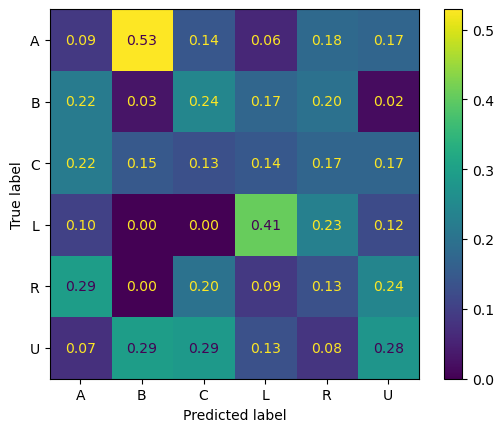

In [9]:
Y_true = np.array([])
Y_pred = np.array([])

letters = ["A", "B", "C", "L", "R", "U"]

for i in range(len(validation_set)):
    annotation, label = validation_set.__getitem__(i)
    Y_true = np.append(Y_true, torch.argmax(label).cpu())
    Y_pred = np.append(Y_pred, torch.argmax(model(annotation.to(device))).cpu())

ConfusionMatrixDisplay.from_predictions(
    Y_true,
    Y_pred, 
    normalize="pred",
    display_labels=letters,
    values_format=".2f"
)
plt.show()